In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import swisseph as swe
obliquity = 23.44

n_planets = 9

f = open("gauquelin.txt", "rt")
data = [s.split('\t') for s in f]
header = data[0]
data = data[2:]
len(data)

8776

In [2]:
print 'Available planets list:'
for i in range(23):
    print i, swe.get_planet_name(i)

Available planets list:
0 Sun
1 Moon
2 Mercury
3 Venus
4 Mars
5 Jupiter
6 Saturn
7 Uranus
8 Neptune
9 Pluto
10 mean Node
11 true Node
12 mean Apogee
13 osc. Apogee
14 Earth
15 Chiron
16 Pholus
17 Ceres
18 Pallas
19 Juno
20 Vesta
21 intp. Apogee
22 intp. Perigee


In [3]:
def convert_angle(s):
    sign = 1.0 if (s[-3]=='N' or s[-3]=='E') else -1.0
    return sign*(float(s[:-3]) + float(s[-2:].lstrip(' ')) / 60.0)

class Person:
    def __init__(self, entry):
        year  = int(entry[0])
        month = int(entry[1])
        day   = int(entry[2])
        hour  = int(entry[6]) + int(entry[9])
        minute = int(entry[7])
        second = float(entry[8])
        julday = swe.julday(year, month, day, hour + minute/60.0 + second/3600.0)
        t = swe.sidtime(julday) * 15
        self.occupation = entry[3]
        lat = convert_angle(entry[10])
        lon = convert_angle(entry[11])
        self.houses = -np.ones(n_planets)
        self.signs  = -np.ones(n_planets)
        for body in range(n_planets):
            p = swe.calc(julday, body)
            self.houses[body] = int(swe.house_pos(t + lon, lat, obliquity, p[0], p[1]))
            self.signs[body] = int(p[0] / 30)
    def get_features(self):
        X = np.zeros(2*12*n_planets)
        for i in range(n_planets):
            X[2*12*i + int(self.houses[i])] = 1
            X[2*12*i + 12 + int(self.signs[i])] = 1
        return X
    def get_target(self):
        return ['C', 'S', 'M'].index(self.occupation)

In [4]:
n = len(data)
X = []
y = []
for i in range(n):
    p = Person(data[i])
    X.append(p.get_features())
    y.append(p.get_target())
X = np.array(X)
y = np.array(y)

In [5]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
clf = LogisticRegression(penalty='l1', C=0.1)
scores = cross_val_score(clf, X, y, cv=10)

print scores
print 'prediction accuracy = ', np.mean(scores), ' +- ' , np.std(scores)/np.sqrt(len(scores))

[ 0.57337884  0.59499431  0.59385666  0.55808656  0.57175399  0.58428246
  0.57468643  0.5673516   0.59246575  0.6130137 ]
prediction accuracy =  0.582387029468  +-  0.00490280264828


In [7]:
print 'baseline accuracy = ', 1.0 * np.sum(y==1) / len(y)

baseline accuracy =  0.415109389243


[]

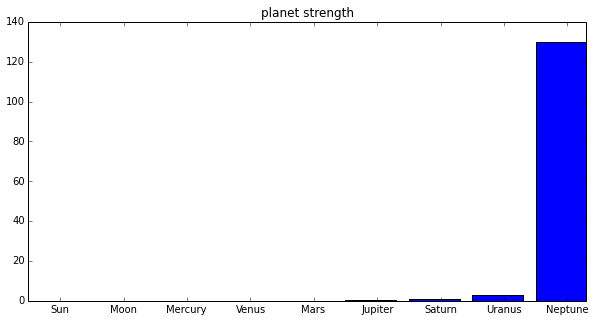

In [8]:
clf.fit(X, y)

planet_strength = np.zeros(n_planets)
for i in range(n_planets):
    for j in range(24):
        planet_strength[i] += np.sum(clf.coef_[:,24*i + j]**2)

plt.figure(figsize=(10,5))
plt.bar(np.arange(n_planets), planet_strength)
plt.xticks(np.arange(n_planets) + 0.5, [swe.get_planet_name(i) for i in range(n_planets)])
plt.title('planet strength')
plt.plot()